In [1]:
import torch
from torch.utils.data import DataLoader
import pandas as pd

from src.utils import (
    align_vocab_and_build_tokenizer,
    exctract_sentences,
    evaluate_model,
    load_checkpoint_weights,
)
from src.data import get_dataset, CustomCollator
from src.models import MeanEmbedder, LSTMEmbedder, BiLSTMEmbedder, BiLSTMPooledEmbedder, SentenceClassificationModel
from src.constants import AvailableEmbedders

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2

/Users/maxbelitsky/miniconda3/envs/acts-nli/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-04-22 20:55:19,097] [INFO] [datasets:config.py:58] PyTorch version 2.2.2 available.


In [2]:
device = torch.device('mps')
batch_size = 64
mlp_hidden_dim = 512

# Initialize the dataset
dataset = get_dataset()
sentences = exctract_sentences(dataset)

# Load/build the tokenizer
tokenizer, vectors = align_vocab_and_build_tokenizer(sentences)

val_dataloader = DataLoader(
    dataset['validation'],
    collate_fn=CustomCollator(tokenizer, device),
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    dataset['test'],
    collate_fn=CustomCollator(tokenizer, device),
    batch_size=batch_size,
    shuffle=True,
)

# Initialize models
CHECKPOINTS = {
    AvailableEmbedders.LSTM: "lstm_2024_04_20_18_00.pt",
    AvailableEmbedders.BI_LSTM: "bi-lstm_2024_04_20_18_58.pt",
    AvailableEmbedders.BI_LSTM_POOL: "bi-lstm-pool_2024_04_20_19_28.pt",
    AvailableEmbedders.MEAN: "mean_2024_04_22_20_20.pt"
}
EMBEDDERS = {
    AvailableEmbedders.LSTM: LSTMEmbedder(vectors),
    AvailableEmbedders.BI_LSTM: BiLSTMEmbedder(vectors),
    AvailableEmbedders.BI_LSTM_POOL: BiLSTMPooledEmbedder(vectors),
    AvailableEmbedders.MEAN: MeanEmbedder(vectors)
}

MODELS = {}
for embedder_name, embedder in EMBEDDERS.items():

    # Initialize the models
    model = SentenceClassificationModel(embedder, mlp_hidden_dim, 3).to(device)

    # Load weights
    load_checkpoint_weights(model, f"models/{CHECKPOINTS[embedder_name]}", device, skip_glove=True)
    MODELS[embedder_name] = model

[2024-04-22 20:55:28,981] [INFO] [src.utils:utils.py:102] Finding all unique tokens
[2024-04-22 20:55:35,344] [INFO] [src.utils:utils.py:28] Found 33841 unique tokens
[2024-04-22 20:55:35,344] [INFO] [src.utils:utils.py:104] Aligning with GloVe vectors
[2024-04-22 20:55:35,345] [INFO] [torchtext.vocab.vectors:vectors.py:172] Loading vectors from .vector_cache/glove.840B.300d.txt.pt
[2024-04-22 20:55:39,794] [INFO] [src.utils:utils.py:49] Found 30734 tokens with embeddings


# Evaluating the models on SNLI

In [3]:
all_results = []
for model_name, model in MODELS.items():

    # Evaluate the model
    val_metrics = evaluate_model(model, val_dataloader)
    test_metrics = evaluate_model(model, test_dataloader)

    # Collect the metrics
    results = {
        "model": model_name,
        "val_accuracy": val_metrics['accuracy'].item(),
        "test_accuracy": test_metrics['accuracy'].item()
    }
    all_results.append(results)

results_df = pd.DataFrame(all_results)
results_df

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,model,val_accuracy,test_accuracy
0,AvailableEmbedders.LSTM,0.810649,0.805195
1,AvailableEmbedders.BI_LSTM,0.805373,0.803166
2,AvailableEmbedders.BI_LSTM_POOL,0.848247,0.844866
3,AvailableEmbedders.MEAN,0.641940,0.649249


# Testing models with a custom hypothesis and premisis

In [4]:
LABEL_NAMES = {
    0: "entailment",
    1: "neutral",
    2: "contradiction"
}

def prepare_sentence(sentence, tokenizer):
    """Tokenize the sentence"""
    tokenized_sentence = tokenizer(sentence, return_tensors="pt").to(device)
    tokenized_sentence['length'] = tokenized_sentence['attention_mask'].sum(dim=1).cpu()
    return tokenized_sentence


def predict_label(model, premise, hypothesis, return_name=True):
    """Predict the label of the given premise and hypothesis"""
    tokenized_premise = prepare_sentence(premise, tokenizer)
    tokenized_hypothesis = prepare_sentence(hypothesis, tokenizer)

    model_output = model(tokenized_premise, tokenized_hypothesis)
    prediction = model_output.argmax(dim=1)

    prediction = prediction.cpu().item()
    if return_name:
        prediction = LABEL_NAMES[prediction]
    return prediction


In [142]:
premise = "two people are shopping in a market."
hypothesis = "there are people at a market."

for name, model in MODELS.items():
    label = predict_label(model, premise, hypothesis)
    print(f"Model {name} predicts: {label}")

Model AvailableEmbedders.LSTM predicts: entailment
Model AvailableEmbedders.BI_LSTM predicts: entailment
Model AvailableEmbedders.BI_LSTM_POOL predicts: entailment
Model AvailableEmbedders.MEAN predicts: entailment


Here all the models predict entailment, which is the correct label for the provided input pair. To test how well the models understand the semantics, we can add a negation to the premise: "two people are shopping in a market." --> "two people are **NOT** shopping in a market". This should result in the "neutral" label, as the information in the premise in not sufficient to make any conclusion about the number of people in the market.

In [143]:
premise = "two people are NOT shopping in a market."
hypothesis = "there are people at a market."

for name, model in MODELS.items():
    label = predict_label(model, premise, hypothesis)
    print(f"Model {name} predicts: {label}")

Model AvailableEmbedders.LSTM predicts: entailment
Model AvailableEmbedders.BI_LSTM predicts: entailment
Model AvailableEmbedders.BI_LSTM_POOL predicts: entailment
Model AvailableEmbedders.MEAN predicts: entailment


Here we can see that none of the models managed to capture the negation. That suggests that the models are likely focused on the content words inside each sentence rather than the function words, which can change the meaning of the sentence completely. Let's try changing the premise again. This time I will change the premise such that the hypothesis should result in a contradiction: "two people are located in a market." --> "**no** people are shopping in a market".

In [154]:
premise = "no people are located in a market."
hypothesis = "there are people at a market."

for name, model in MODELS.items():
    label = predict_label(model, premise, hypothesis)
    print(f"Model {name} predicts: {label}")

Model AvailableEmbedders.LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM_POOL predicts: entailment
Model AvailableEmbedders.MEAN predicts: entailment


This time the LSTM and BiLSTM models predicted contradiction. Let's try a premise that doesn't share any words with a hypothesis but has the same meaning.

In [157]:
premise = "no human beings happen to be located in a store."
hypothesis = "there are people at the market."

for name, model in MODELS.items():
    label = predict_label(model, premise, hypothesis)
    print(f"Model {name} predicts: {label}")

Model AvailableEmbedders.LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM_POOL predicts: contradiction
Model AvailableEmbedders.MEAN predicts: contradiction


Now all the models predict the contradiction. This suggests that the trained models capture similarity between words and repy heavily on this information in their predictions, whereas they struggle with the global meaning.

Two more examples with the correct label being neutral are:

Premise: "A man is walking a dog". Hypothesis: "No cat is outside".

Premise: "Two men sitting in the sun". Hypothesis: "Nobody is sitting in the shade".

In both cases the information in the premise can slightly mislead the model. This could be attributed to the fact that the models capture word relations. For instance, in the first example, "cat" and "dog" are "opposites". The model assumes that if there is a dog, then there is no cat. The same hold for the second example. It's either the sun or the shade, thus the models focuses the "opposite" meaning of the these words and doesn't not take the meaning of the whole sentence into account, which signifies the lack of contextual understanding.

In [159]:
premise = "A man is walking a dog"
hypothesis = "No cat is outside"

for name, model in MODELS.items():
    label = predict_label(model, premise, hypothesis)
    print(f"Model {name} predicts: {label}")

Model AvailableEmbedders.LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM_POOL predicts: contradiction
Model AvailableEmbedders.MEAN predicts: contradiction


In [160]:
premise = "Two men sitting in the sun"
hypothesis = "Nobody is sitting in the shade"

for name, model in MODELS.items():
    label = predict_label(model, premise, hypothesis)
    print(f"Model {name} predicts: {label}")

Model AvailableEmbedders.LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM predicts: contradiction
Model AvailableEmbedders.BI_LSTM_POOL predicts: contradiction
Model AvailableEmbedders.MEAN predicts: contradiction


# Error analysis

In [34]:
def cosine_similarity(sent1, sent2, model, tokenizer):
    """Calculate the cosine similarity between two sentences"""
    sent1 = prepare_sentence(sent1, tokenizer)
    sent2 = prepare_sentence(sent2, tokenizer)

    emb1 = model.embedder(sent1)
    emb2 = model.embedder(sent2)

    return torch.nn.functional.cosine_similarity(emb1, emb2).cpu().item()


def find_incorrect_predictions(model, dataloader, tokenizer):
    """Find the incorrect predictions of the model"""
    incorrect = []
    correct = []
    y_true = []
    y_pred = []

    for batch in dataloader:
        premise = batch['premises']
        hypothesis = batch['hypotheses']
        labels = batch['labels']

        predictions = model(premise, hypothesis).argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

        premises = tokenizer.batch_decode(premise['input_ids'], skip_special_tokens=True)
        hypotheses = tokenizer.batch_decode(hypothesis['input_ids'], skip_special_tokens=True)

        # Find fails and correct predictions
        for i, (prem, hypo, label, pred) in enumerate(zip(premises, hypotheses, labels, predictions)):
            if label != pred:
                incorrect.append((prem, hypo, LABEL_NAMES[label.item()], LABEL_NAMES[pred.item()]))
            else:
                correct.append((prem, hypo, LABEL_NAMES[label.item()], LABEL_NAMES[pred.item()]))

    return incorrect, correct, y_true, y_pred


def plot_confusion_matrix(y_true, y_pred, name):
    """Plot the confusion matrix for the model predictions"""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion matrix for {name}")
    plt.show()


def print_incorrect_predictions(model_incorrect_predictions, n=5):
    """Print the incorrect predictions"""
    for name, (incorrect, _) in model_incorrect_predictions.items():
        print(f"Incorrect predictions for model {name}")
        for prem, hypo, true, pred in incorrect[:n]:
            print(f"Premise: {prem}")
            print(f"Hypothesis: {hypo}")
            print(f"True label: {true}")
            print(f"Predicted label: {pred}")
            print()
        print("-"*100)

### Which classes are the most problematic for each model?

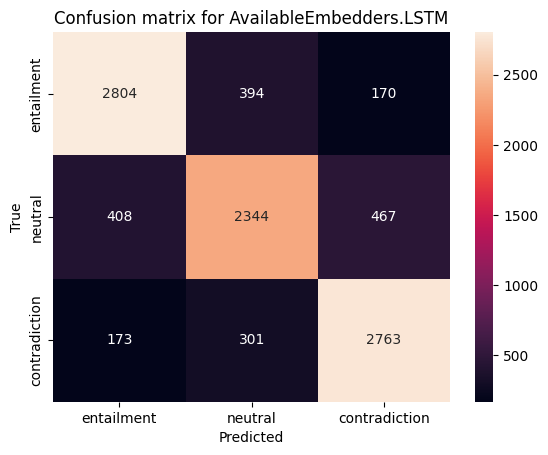

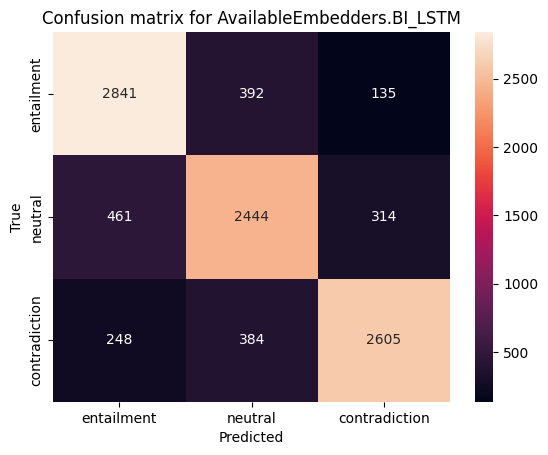

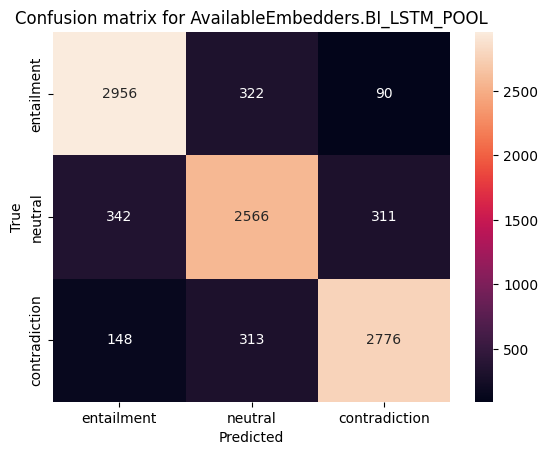

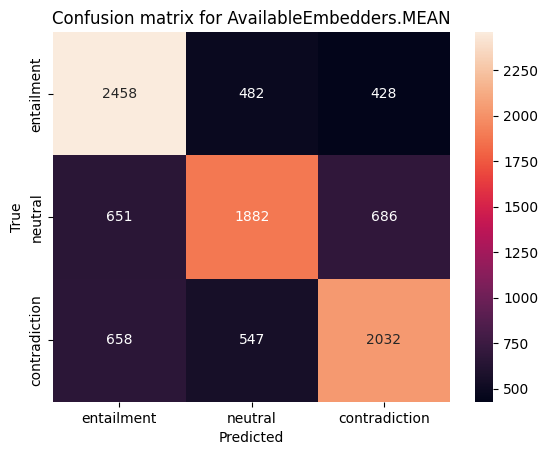

In [10]:
model_incorrect_predictions = {}
for name, model in MODELS.items():
    incorrect, correct, y_true, y_pred = find_incorrect_predictions(model, test_dataloader, tokenizer)
    model_incorrect_predictions[name] = (incorrect, correct)
    plot_confusion_matrix(y_true, y_pred, name)


In [115]:
print_incorrect_predictions(model_incorrect_predictions, n=2)

Incorrect predictions for model AvailableEmbedders.LSTM
Premise: people in motion down a city sidewalk.
Hypothesis: people are flying down a sidewalk.
True label: neutral
Predicted label: contradiction

Premise: two workers with leaf blowers blow orange leaves off patches of grass next to a wet sidewalk.
Hypothesis: two workers blowing leaves on a fall day
True label: neutral
Predicted label: entailment

----------------------------------------------------------------------------------------------------
Incorrect predictions for model AvailableEmbedders.BI_LSTM
Premise: a car is loaded with items on the top.
Hypothesis: the car is a convertible.
True label: contradiction
Predicted label: neutral

Premise: a boy in sports themed pajamas is in front of a christmas tree.
Hypothesis: the kid is in front of the tree
True label: entailment
Predicted label: neutral

----------------------------------------------------------------------------------------------------
Incorrect predictions for m

All models exhibit the same pattern: they rarely misclassify "entailment" as "contradiction" and a bit more often "contradiction" is misclassified as "entailment". However, the most problematic class is "neutral", especially when "neautral" is the true label. Examples of this can be observed in the previous section.

### Can the norms of the token embeddings tell us something about the importance of these tokens?

In [96]:
def get_token_importance(sentence, model):
    # Get token embeddings
    tokenized_sentence = prepare_sentence(sentence, tokenizer)
    token_emb = model.embedder.embedding(tokenized_sentence['input_ids'])
    with torch.no_grad():
        token_emb = model.embedder.lstm(token_emb)[0]

    # Compute the norm of each token embedding
    token_norms = torch.norm(token_emb, dim=2).squeeze().cpu().numpy()
    tokens = tokenizer.tokenize(sentence)
    return tokens, token_norms


def plot_token_importance(sentence_1, sentence_2, model):
    tokens_1, token_norms_1 = get_token_importance(sentence_1, model)
    tokens_2, token_norms_2 = get_token_importance(sentence_2, model)

    # Plot the token importance in a stacked bar plot
    plt.figure(figsize=(15, 5))
    sns.barplot(x=tokens_1, y=token_norms_1, errorbar=None, alpha=0.8)
    sns.barplot(x=tokens_2, y=token_norms_2, errorbar=None, alpha=0.8)
    plt.title(f"Token importance for model {model.embedder.__class__.__name__}")
    plt.show()


Premise: a black and white bird with a yellow beak is flying.
Hypothesis: bird flying outside against the sky
True label: neutral, but the model predicted: entailment


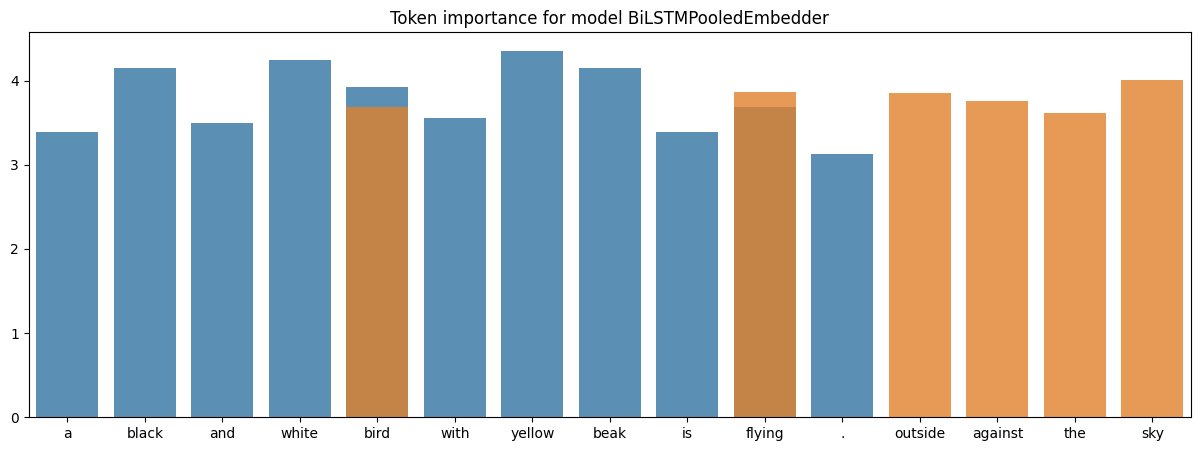

In [164]:
# Visualize the word importance for a misclassified example
premise, hypothesis, label, prediction = model_incorrect_predictions[AvailableEmbedders.BI_LSTM_POOL][0][0]
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"True label: {label}, but the model predicted: {prediction}")

plot_token_importance(premise, hypothesis, MODELS[AvailableEmbedders.BI_LSTM_POOL])

Premise: 3 young man in hoods standing in the middle of a quiet street facing the camera.
Hypothesis: three hood wearing people pose for a picture.
True label: entailment, but the model predicted: neutral


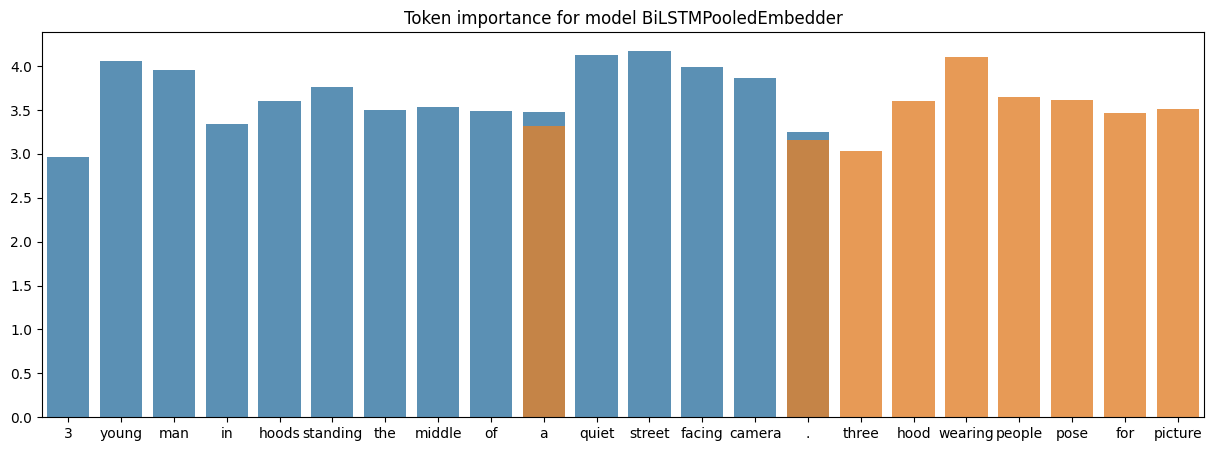

In [165]:
# Visualize the word importance for a misclassified example
premise, hypothesis, label, prediction = model_incorrect_predictions[AvailableEmbedders.BI_LSTM_POOL][0][1]
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"True label: {label}, but the model predicted: {prediction}")

plot_token_importance(premise, hypothesis, MODELS[AvailableEmbedders.BI_LSTM_POOL])

Premise: an african man is being dragged though wet mud by two cows whilst other people watch.
Hypothesis: a man is attempting to run away.
True label: neutral, but the model predicted: contradiction


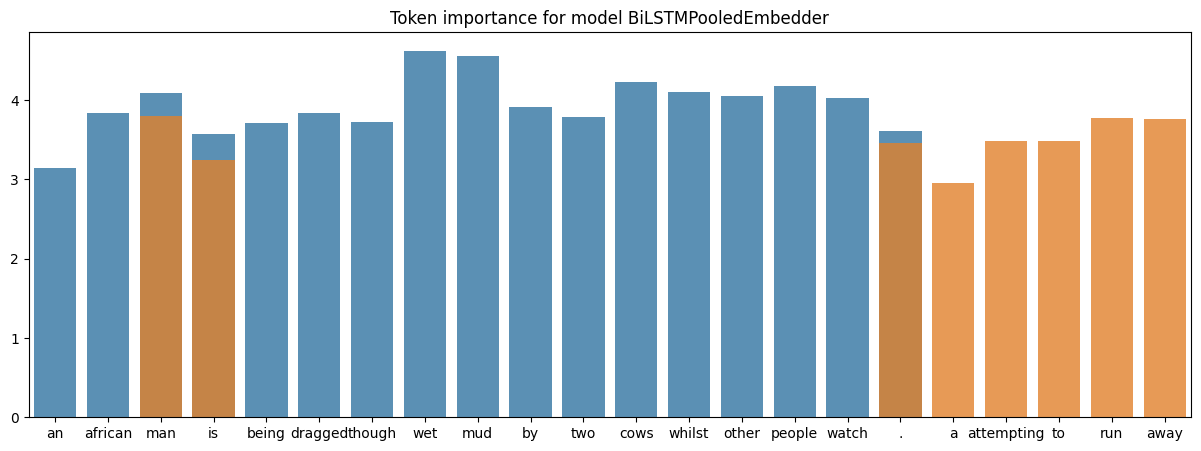

In [166]:
# Visualize the word importance for a misclassified example
premise, hypothesis, label, prediction = model_incorrect_predictions[AvailableEmbedders.BI_LSTM_POOL][0][2]
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"True label: {label}, but the model predicted: {prediction}")

plot_token_importance(premise, hypothesis, MODELS[AvailableEmbedders.BI_LSTM_POOL])

Premise: three people wearing black blindfolds near a " salvar o planeta " sign.
Hypothesis: they can all see
True label: contradiction, but the model predicted: neutral


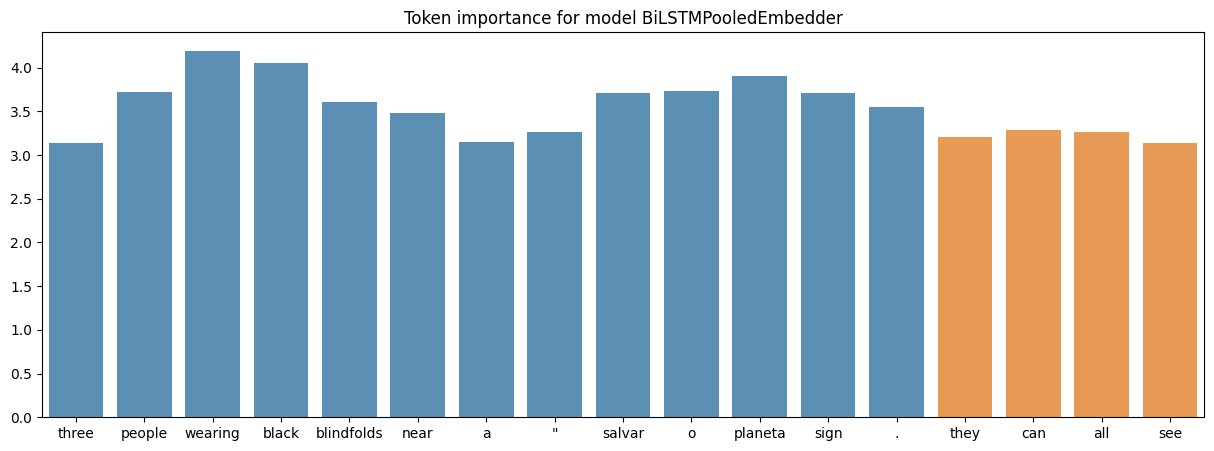

In [167]:
# Visualize the word importance for a misclassified example
premise, hypothesis, label, prediction = model_incorrect_predictions[AvailableEmbedders.BI_LSTM_POOL][0][3]
print(f"Premise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"True label: {label}, but the model predicted: {prediction}")

plot_token_importance(premise, hypothesis, MODELS[AvailableEmbedders.BI_LSTM_POOL])

Here we can see that the BiLSTM model with max pooling misclassifies examples where there are not a lot of overlapping words between the premise and the hypothesis. Additionally, the magnitudes of the embeddings of content words are much larger than the magnitudes of the embeddings of function words. Finally, it can be observed that the magnitudes of the most important words for each case are not the largest.

Another example from the first section:

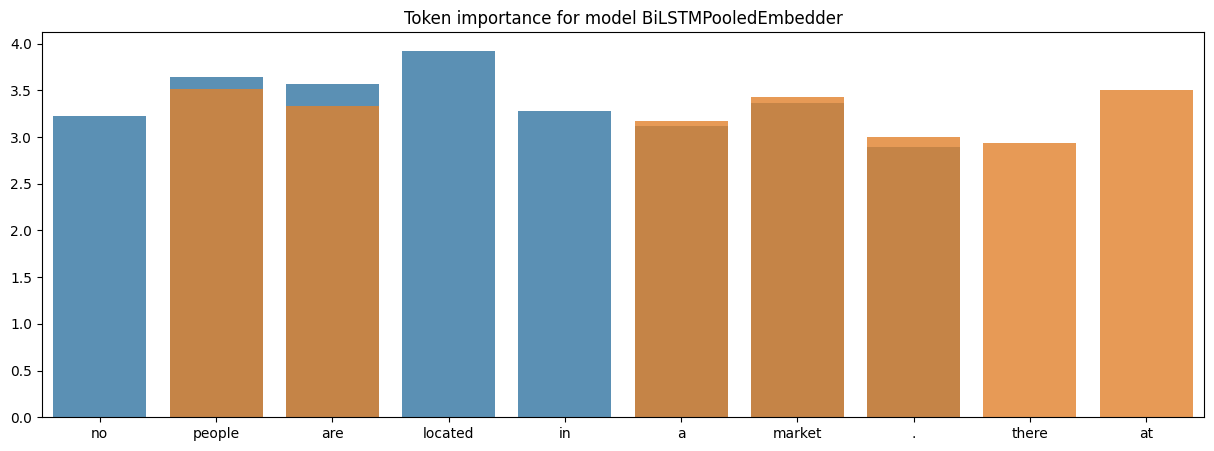

In [163]:
premise = "no people are located in a market."
hypothesis = "there are people at a market."

plot_token_importance(premise, hypothesis, MODELS[AvailableEmbedders.BI_LSTM_POOL])

The norms of the tokens "no", "in", "a", ".", "there" have smaller magnitudes compared to the content words like "people" and "located".